In [1]:
from modules import expectedMultiBleu
import numpy as np
import torch
from torch.cuda import LongTensor, FloatTensor
from torch.autograd import Variable
from torch.nn import Module, functional as F
from modules.expectedBLEU import bleu as ebleu
from modules.expectedMultiBleu import bleu, calculate_overlap
from modules.matrixBLEU import mBLEU
from matplotlib import pyplot as plt
from modules.utils import CUDA_wrapper
import time
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def generate_batch_references(references_lengths, vocab_size):
    def _gen_padded_ref(l):
        ref = np.random.choice(vocab_size, size=l, replace=True)
        padding = np.array([0] * (max_len - l), dtype=int)
        return np.concatenate((ref, padding)).tolist()
    max_len = np.max(references_lengths)
    res = [_gen_padded_ref(l)\
           for l in references_lengths]
    # res = np.stack(res)
    return res

def _all_idx(idx, axis):
    print(tuple(map(slice, idx.shape)))
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

def onehot_initialization(a, vocab_size):
    ncols = vocab_size
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[_all_idx(a, axis=2)] = 1
    return out

class MySoftmax(Module):

    def forward(self, input_):
        batch_size = input_.size()[0]
        output_ = torch.stack([F.softmax(input_[i]) for i in range(batch_size)], 0)
        return output_

In [3]:
sm = MySoftmax()
np.random.seed(3)
torch.manual_seed(2)
low_len = 8
hight_len = 10
batch_size = 200
translation_len = 10
vocab_size = 20000
references_lengths = np.random.randint(low=low_len,\
                                high=hight_len + 1, size=batch_size)
t = Variable(CUDA_wrapper(\
            torch.randn((batch_size, translation_len, vocab_size))),\
    requires_grad=True)
references_batch = generate_batch_references(references_lengths, vocab_size)

In [4]:
opt = torch.optim.Adam([t], lr=0.1)
grad_norms = []
bleu_lb = []
start_time = time.time()
for i in range(200):
    probs = sm(t)
    b = bleu(probs, references_batch, \
        LongTensor([translation_len] * batch_size), references_lengths, smooth=True)
    b[0].backward()
    bleu_lb.append(b[0].data[0])
    opt.step()
    print(b[0].data[0])
    grad_norms.append(t.grad.data.norm())
print('-'*10 + 'TIME' + '-'*10)
print(time.time() - start_time)
print('-' * 10 + ' FINAL ' + '-'* 10)
print(bleu(probs, references_batch, \
    LongTensor([translation_len] * batch_size), references_lengths, smooth=False))

Variable containing:
 8.7076e-01
 3.4756e-05
 1.3246e-09
 4.7661e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0006936021381989121


Variable containing:
 8.7380e-01
 3.5001e-05
 1.3384e-09
 4.8309e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0006938846199773252


Variable containing:
 8.7994e-01
 3.5497e-05
 1.3664e-09
 4.9637e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0006944526685401797


Variable containing:
 8.8949e-01
 3.6276e-05
 1.4108e-09
 5.1760e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0006953327101655304


Variable containing:
 9.0268e-01
 3.7364e-05
 1.4737e-09
 5.4806e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0006965433130972087


Variable containing:
 9.1973e-01
 3.8794e-05
 1.5578e-09
 5.8944e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0006980980979278684


Variable containing:
 9.4085e-01
 4.0604e-05
 1.6662e-09
 6.4395e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007000110927037895


Variable containing:
 9.6631e-01
 4.2838e-05
 1.8035e-09
 7.1457e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007022956269793212


Variable containing:
 9.9639e-01
 4.5555e-05
 1.9750e-09
 8.0535e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007049670093692839


Variable containing:
 1.0314e+00
 4.8825e-05
 2.1881e-09
 9.2173e-14
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007080417708493769


Variable containing:
 1.0719e+00
 5.2737e-05
 2.4522e-09
 1.0711e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007115390617400408


Variable containing:
 1.1181e+00
 5.7399e-05
 2.7794e-09
 1.2635e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007154798367992043


Variable containing:
 1.1708e+00
 6.2944e-05
 3.1855e-09
 1.5127e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007198880193755031


Variable containing:
 1.2305e+00
 6.9538e-05
 3.6911e-09
 1.8377e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007247882895171642


Variable containing:
 1.2980e+00
 7.7385e-05
 4.3234e-09
 2.2648e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007302092271856964


Variable containing:
 1.3741e+00
 8.6735e-05
 5.1178e-09
 2.8310e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007361813331954181


Variable containing:
 1.4597e+00
 9.7900e-05
 6.1217e-09
 3.5883e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007427368545904756


Variable containing:
 1.5561e+00
 1.1127e-04
 7.3977e-09
 4.6110e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007499101338908076


Variable containing:
 1.6645e+00
 1.2732e-04
 9.0297e-09
 6.0053e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007577385986223817


Variable containing:
 1.7863e+00
 1.4666e-04
 1.1131e-08
 7.9252e-13
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007662612479180098


Variable containing:
 1.9234e+00
 1.7004e-04
 1.3854e-08
 1.0596e-12
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007755181286484003


Variable containing:
 2.0775e+00
 1.9841e-04
 1.7407e-08
 1.4347e-12
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007855521398596466


Variable containing:
 2.2511e+00
 2.3296e-04
 2.2075e-08
 1.9672e-12
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0007964072283357382


Variable containing:
 2.4466e+00
 2.7520e-04
 2.8251e-08
 2.7304e-12
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0008081292035058141


Variable containing:
 2.6671e+00
 3.2707e-04
 3.6477e-08
 3.8356e-12
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0008207649807445705


Variable containing:
 2.9160e+00
 3.9098e-04
 4.7511e-08
 5.4518e-12
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.000834362639579922


Variable containing:
 3.1972e+00
 4.7008e-04
 6.2413e-08
 7.8389e-12
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0008489714236930013


Variable containing:
 3.5153e+00
 5.6834e-04
 8.2674e-08
 1.1399e-11
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0008646411588415504


Variable containing:
 3.8756e+00
 6.9092e-04
 1.1041e-07
 1.6759e-11
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0008814239990897477


Variable containing:
 4.2842e+00
 8.4442e-04
 1.4863e-07
 2.4907e-11
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0008993709343485534


Variable containing:
 4.7481e+00
 1.0374e-03
 2.0165e-07
 3.7409e-11
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0009185353992506862


Variable containing:
 5.2754e+00
 1.2810e-03
 2.7567e-07
 5.6765e-11
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0009389714105054736


Variable containing:
 5.8757e+00
 1.5896e-03
 3.7966e-07
 8.7007e-11
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0009607348474673927


Variable containing:
 6.5596e+00
 1.9822e-03
 5.2667e-07
 1.3467e-10
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0009838816476985812


Variable containing:
 7.3400e+00
 2.4832e-03
 7.3577e-07
 2.1044e-10
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0010084708919748664


Variable containing:
 8.2314e+00
 3.1250e-03
 1.0350e-06
 3.3192e-10
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0010345646878704429


Variable containing:
 9.2506e+00
 3.9500e-03
 1.4656e-06
 5.2828e-10
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0010622272966429591


Variable containing:
 1.0417e+01
 5.0142e-03
 2.0888e-06
 8.4821e-10
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.001091528101824224


Variable containing:
 1.1754e+01
 6.3914e-03
 2.9958e-06
 1.3736e-09
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0011225425405427814


Variable containing:
 1.3286e+01
 8.1792e-03
 4.3228e-06
 2.2429e-09
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.001155355479568243


Variable containing:
 1.5045e+01
 1.0507e-02
 6.2744e-06
 3.6921e-09
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0011900619138032198


Variable containing:
 1.7063e+01
 1.3547e-02
 9.1590e-06
 6.1252e-09
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0012267740676179528


Variable containing:
 1.9382e+01
 1.7527e-02
 1.3443e-05
 1.0239e-08
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0012656243052333593


Variable containing:
 2.2047e+01
 2.2753e-02
 1.9836e-05
 1.7243e-08
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.001306775026023388


Variable containing:
 2.5109e+01
 2.9630e-02
 2.9419e-05
 2.9244e-08
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0013504299568012357


Variable containing:
 2.8626e+01
 3.8700e-02
 4.3843e-05
 4.9945e-08
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0013968468410894275


Variable containing:
 3.2666e+01
 5.0686e-02
 6.5646e-05
 8.5875e-08
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0014463576953858137


Variable containing:
 3.7303e+01
 6.6554e-02
 9.8732e-05
 1.4862e-07
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0014993962831795216


Variable containing:
 4.2620e+01
 8.7594e-02
 1.4912e-04
 2.5884e-07
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0015565225621685386


Variable containing:
 4.8708e+01
 1.1552e-01
 2.2613e-04
 4.5351e-07
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0016184664564207196


Variable containing:
 5.5670e+01
 1.5261e-01
 3.4415e-04
 7.9908e-07
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.001686161500401795


Variable containing:
 6.3614e+01
 2.0189e-01
 5.2548e-04
 1.4152e-06
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0017607914051041007


Variable containing:
 7.2657e+01
 2.6734e-01
 8.0449e-04
 2.5171e-06
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0018438133411109447


Variable containing:
 8.2921e+01
 3.5417e-01
 1.2341e-03
 4.4918e-06
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0019369730725884438


Variable containing:
 9.4534e+01
 4.6918e-01
 1.8954e-03
 8.0316e-06
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0020422879606485367


Variable containing:
 1.0762e+02
 6.2113e-01
 2.9113e-03
 1.4367e-05
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.00216198549605906


Variable containing:
 1.2231e+02
 8.2123e-01
 4.4671e-03
 2.5669e-05
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0022984168026596308


Variable containing:
 1.3871e+02
 1.0837e+00
 6.8393e-03
 4.5718e-05
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0024539472069591284


Variable containing:
 1.5693e+02
 1.4265e+00
 1.0435e-02
 8.1034e-05
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0026308789383620024


Variable containing:
 1.7706e+02
 1.8718e+00
 1.5847e-02
 1.4268e-04
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0028314150404185057


Variable containing:
 1.9914e+02
 2.4472e+00
 2.3927e-02
 2.4912e-04
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.00305770942941308


Variable containing:
 2.2322e+02
 3.1860e+00
 3.5880e-02
 4.3061e-04
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0033120184671133757


Variable containing:
 2.4928e+02
 4.1285e+00
 5.3389e-02
 7.3573e-04
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.003596941940486431


Variable containing:
 2.7728e+02
 5.3226e+00
 7.8777e-02
 1.2408e-03
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.003915729001164436


Variable containing:
 3.0712e+02
 6.8237e+00
 1.1523e-01
 2.0634e-03
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.004272688180208206


Variable containing:
 3.3869e+02
 8.6954e+00
 1.6713e-01
 3.3831e-03
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.004673715680837631


Variable containing:
 3.7182e+02
 1.1010e+01
 2.4055e-01
 5.4744e-03
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.005126927979290485


Variable containing:
 4.0629e+02
 1.3847e+01
 3.4393e-01
 8.7624e-03
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.005643246695399284


Variable containing:
 441.8869
  17.2933
   0.4886
   0.0139
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.006236579269170761


Variable containing:
 478.3571
  21.4393
   0.6896
   0.0220
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.006923485081642866


Variable containing:
 515.4325
  26.3763
   0.9659
   0.0347
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.007723068352788687


Variable containing:
 552.8334
  32.1946
   1.3418
   0.0547
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.008657336235046387


Variable containing:
 590.2804
  38.9830
   1.8477
   0.0859
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.00975191593170166


Variable containing:
 627.5074
  46.8274
   2.5198
   0.1338
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.011037281714379787


Variable containing:
 664.2649
  55.8083
   3.4011
   0.2057
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.012550365179777145


Variable containing:
 700.3286
  65.9995
   4.5416
   0.3112
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.014335940591990948


Variable containing:
 735.5217
  77.4664
   5.9981
   0.4618
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.016445009037852287


Variable containing:
 769.7251
  90.2626
   7.8319
   0.6705
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0189288929104805


Variable containing:
 802.8716
 104.4245
  10.1052
   0.9514
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.021832415834069252


Variable containing:
 834.9225
 119.9684
  12.8784
   1.3192
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.02519027143716812


Variable containing:
 865.8572
 136.8889
  16.2062
   1.7890
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.029023844748735428


Variable containing:
 895.6607
 155.1579
  20.1348
   2.3747
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.033339571207761765


Variable containing:
 924.3082
 174.7270
  24.7033
   3.0912
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.03813660889863968


Variable containing:
 951.7995
 195.5226
  29.9454
   3.9571
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.04341712221503258


Variable containing:
 978.1956
 217.4468
  35.8896
   4.9970
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.049188777804374695


Variable containing:
 1003.5726
  240.3840
   42.5567
    6.2408
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.05546063557267189


Variable containing:
 1027.9928
  264.1954
   49.9644
    7.7250
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.06224508211016655


Variable containing:
 1051.5060
  288.7137
   58.1300
    9.4913
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.06955217570066452


Variable containing:
 1074.1470
  313.7686
   67.0665
   11.5869
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.07738916575908661


Variable containing:
 1095.9232
  339.1959
   76.7778
   14.0620
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.0857558324933052


Variable containing:
 1116.8142
  364.8248
   87.2544
   16.9637
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.09463376551866531


Variable containing:
 1136.7894
  390.4711
   98.4737
   20.3301
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.10398443788290024


Variable containing:
 1155.8416
  415.9545
  110.4024
   24.1860
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.11375139653682709


Variable containing:
 1174.0114
  441.1101
  123.0041
   28.5437
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.12387126684188843


Variable containing:
 1191.3627
  465.8104
  136.2373
   33.4027
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.1342783123254776


Variable containing:
 1207.9343
  489.9669
  150.0474
   38.7470
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.14490078389644623


Variable containing:
 1223.7147
  513.5516
  164.3704
   44.5420
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.15566317737102509


Variable containing:
 1238.6692
  536.5884
  179.1227
   50.7337
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.16648566722869873


Variable containing:
 1252.8336
  559.0809
  194.1883
   57.2584
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.1772874891757965


Variable containing:
 1266.3159
  580.9765
  209.4293
   64.0445
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.1879875659942627


Variable containing:
 1279.1970
  602.1891
  224.7073
   71.0192
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.19851049780845642


Variable containing:
 1291.4937
  622.6292
  239.8978
   78.1211
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2087961584329605


Variable containing:
 1303.2075
  642.2180
  254.8867
   85.3019
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2187991440296173


Variable containing:
 1314.3688
  660.8918
  269.5633
   92.5151
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2284802943468094


Variable containing:
 1325.0002
  678.6168
  283.8369
   99.7141
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2378077507019043


Variable containing:
 1335.0853
  695.3936
  297.6461
  106.8544
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.24675920605659485


Variable containing:
 1344.5883
  711.2482
  310.9479
  113.8923
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2553181052207947


Variable containing:
 1353.5046
  726.2177
  323.7112
  120.7814
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.26347124576568604


Variable containing:
 1361.8203
  740.3707
  335.9320
  127.4849
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2712186574935913


Variable containing:
 1369.5487
  753.8141
  347.6413
  133.9925
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2785852551460266


Variable containing:
 1376.7776
  766.6609
  358.8804
  140.3160
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2856122851371765


Variable containing:
 1383.6097
  778.9933
  369.6812
  146.4764
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.2923396825790405


Variable containing:
 1390.0958
  790.8486
  380.0585
  152.4896
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.29879263043403625


Variable containing:
 1396.2512
  802.2181
  390.0031
  158.3516
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3049745559692383


Variable containing:
 1402.1140
  813.0411
  399.4706
  164.0205
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.31085968017578125


Variable containing:
 1407.7056
  823.2317
  408.3954
  169.4264
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.316402405500412


Variable containing:
 1413.0132
  832.7228
  416.7220
  174.5029
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3215615451335907


Variable containing:
 1418.0005
  841.4993
  424.4342
  179.2099
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3263196647167206


Variable containing:
 1422.6256
  849.6092
  431.5699
  183.5397
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3306894600391388


Variable containing:
 1426.8680
  857.1573
  438.2111
  187.5137
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3347111642360687


Variable containing:
 1430.7377
  864.2787
  444.4751
  191.1812
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.33844712376594543


Variable containing:
 1434.2773
  871.0932
  450.4891
  194.6099
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.34196892380714417


Variable containing:
 1437.5466
  877.6754
  456.3507
  197.8719
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.34533950686454773


Variable containing:
 1440.5890
  884.0432
  462.1027
  201.0370
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.348602831363678


Variable containing:
 1443.4139
  890.1603
  467.7504
  204.1704
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.35178589820861816


Variable containing:
 1445.9946
  895.9706
  473.2889
  207.3256
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.35490334033966064


Variable containing:
 1448.2987
  901.4325
  478.7151
  210.5320
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3579607903957367


Variable containing:
 1450.3112
  906.5350
  484.0340
  213.7971
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.36095958948135376


Variable containing:
 1452.0551
  911.3057
  489.2506
  217.1096
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3638993501663208


Variable containing:
 1453.5953
  915.8040
  494.3616
  220.4473
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3667796850204468


Variable containing:
 1455.0105
  920.1104
  499.3580
  223.7882
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.36960265040397644


Variable containing:
 1456.3689
  924.3104
  504.2252
  227.1132
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.37237071990966797


Variable containing:
 1457.7083
  928.4666
  508.9302
  230.3914
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.37507444620132446


Variable containing:
 1459.0251
  932.6104
  513.4265
  233.5811
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.37769222259521484


Variable containing:
 1460.2963
  936.7446
  517.6708
  236.6487
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3802024722099304


Variable containing:
 1461.4990
  940.8475
  521.6374
  239.5822
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3825933635234833


Variable containing:
 1462.6221
  944.8859
  525.3270
  242.3894
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3848652243614197


Variable containing:
 1463.6649
  948.8243
  528.7677
  245.0846
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3870261609554291


Variable containing:
 1464.6390
  952.6271
  531.9992
  247.6746
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.38908395171165466


Variable containing:
 1465.5675
  956.2521
  535.0514
  250.1527
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3910394310951233


Variable containing:
 1466.4828
  959.6552
  537.9368
  252.5021
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.392886757850647


Variable containing:
 1467.4181
  962.8052
  540.6588
  254.7061
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.39461982250213623


Variable containing:
 1468.4005
  965.6998
  543.2255
  256.7585
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3962400257587433


Variable containing:
 1469.4441
  968.3625
  545.6545
  258.6681
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.3977580964565277


Variable containing:
 1470.5391
  970.8260
  547.9673
  260.4515
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.39918747544288635


Variable containing:
 1471.6504
  973.1157
  550.1793
  262.1201
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.40053611993789673


Variable containing:
 1472.7279
  975.2461
  552.3001
  263.6743
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4018044173717499


Variable containing:
 1473.7240
  977.2203
  554.3314
  265.1068
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4029873013496399


Variable containing:
 1474.6074
  979.0273
  556.2675
  266.4113
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.40407833456993103


Variable containing:
 1475.3699
  980.6500
  558.0974
  267.5925
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4050752520561218


Variable containing:
 1476.0205
  982.0824
  559.8127
  268.6666
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.40598297119140625


Variable containing:
 1476.5856
  983.3409
  561.4087
  269.6542
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.40681192278862


Variable containing:
 1477.0985
  984.4635
  562.8858
  270.5721
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.40757495164871216


Variable containing:
 1477.5854
  985.4941
  564.2524
  271.4328
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4082847237586975


Variable containing:
 1478.0634
  986.4720
  565.5288
  272.2496
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4089551568031311


Variable containing:
 1478.5398
  987.4254
  566.7442
  273.0407
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.40960195660591125


Variable containing:
 1479.0148
  988.3729
  567.9323
  273.8260
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.41024050116539


Variable containing:
 1479.4891
  989.3293
  569.1218
  274.6233
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.410884290933609


Variable containing:
 1479.9696
  990.3102
  570.3273
  275.4444
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4115423858165741


Variable containing:
 1480.4690
  991.3351
  571.5474
  276.2929
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.41221868991851807


Variable containing:
 1480.9943
  992.4208
  572.7707
  277.1688
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4129135012626648


Variable containing:
 1481.5331
  993.5790
  573.9965
  278.0798
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4136297106742859


Variable containing:
 1482.0488
  994.8225
  575.2518
  279.0495
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4143797755241394


Variable containing:
 1482.4939
  996.1660
  576.5902
  280.1133
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4151843786239624


Variable containing:
 1482.8309
  997.6202
  578.0756
  281.3052
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.41606590151786804


Variable containing:
 1483.0529
  999.1796
  579.7595
  282.6446
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.41703930497169495


Variable containing:
 1483.1876
 1000.8165
  581.6635
  284.1299
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.41810640692710876


Variable containing:
 1483.2820
 1002.4885
  583.7681
  285.7368
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.41925323009490967


Variable containing:
 1483.3842
 1004.1539
  586.0167
  287.4202
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4204517602920532


Variable containing:
 1483.5293
 1005.7885
  588.3340
  289.1241
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4216678738594055


Variable containing:
 1483.7395
 1007.3852
  590.6525
  290.8007
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4228728711605072


Variable containing:
 1484.0242
 1008.9470
  592.9297
  292.4237
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4240509271621704


Variable containing:
 1484.3857
 1010.4766
  595.1482
  293.9881
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.42519766092300415


Variable containing:
 1484.8217
 1011.9783
  597.3027
  295.5013
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.42631539702415466


Variable containing:
 1485.3223
 1013.4636
  599.4012
  296.9854
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4274141490459442


Variable containing:
 1485.8754
 1014.9588
  601.4739
  298.4846
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.42851722240448


Variable containing:
 1486.4702
 1016.5054
  603.5768
  300.0652
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.42966172099113464


Variable containing:
 1487.0996
 1018.1442
  605.7717
  301.7955
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4308866560459137


Variable containing:
 1487.7545
 1019.8943
  608.0984
  303.7190
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.43221530318260193


Variable containing:
 1488.4116
 1021.7383
  610.5482
  305.8295
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4336398243904114


Variable containing:
 1489.0361
 1023.6223
  613.0618
  308.0617
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.43511784076690674


Variable containing:
 1489.5844
 1025.4757
  615.5527
  310.3079
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.43658503890037537


Variable containing:
 1490.0181
 1027.2380
  617.9452
  312.4626
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4379817843437195


Variable containing:
 1490.3115
 1028.8765
  620.2064
  314.4619
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.43927502632141113


Variable containing:
 1490.4565
 1030.3833
  622.3452
  316.2920
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.44046053290367126


Variable containing:
 1490.4603
 1031.7639
  624.3879
  317.9657
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.44154906272888184


Variable containing:
 1490.3448
 1033.0229
  626.3538
  319.4970
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.44255128502845764


Variable containing:
 1490.1365
 1034.1665
  628.2480
  320.8924
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.44347330927848816


Variable containing:
 1489.8571
 1035.2118
  630.0702
  322.1588
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4443211555480957


Variable containing:
 1489.5242
 1036.1906
  631.8222
  323.3137
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4451061487197876


Variable containing:
 1489.1594
 1037.1405
  633.5081
  324.3858
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4458446800708771


Variable containing:
 1488.7927
 1038.0928
  635.1277
  325.4059
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4465530216693878


Variable containing:
 1488.4595
 1039.0654
  636.6766
  326.3936
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.447241872549057


Variable containing:
 1488.1869
 1040.0623
  638.1508
  327.3542
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4479147791862488


Variable containing:
 1487.9918
 1041.0717
  639.5511
  328.2886
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4485723674297333


Variable containing:
 1487.8831
 1042.0674
  640.8818
  329.2008
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.4492146968841553


Variable containing:
 1487.8678
 1043.0133
  642.1384
  330.0950
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.44983917474746704


Variable containing:
 1487.9413
 1043.8750
  643.3074
  330.9677
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.45043811202049255


Variable containing:
 1488.0852
 1044.6328
  644.3746
  331.8100
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.45100274682044983


Variable containing:
 1488.2723
 1045.2896
  645.3364
  332.6196
[torch.cuda.FloatTensor of size 4 (GPU 0)]



-0.451529860496521
----------TIME----------
367.7847464084625
---------- FINAL ----------
(Variable containing:
-0.4511
[torch.cuda.FloatTensor of size 1 (GPU 0)]
, Variable containing:
 0.7441
 0.5807
 0.4033
 0.2376
[torch.cuda.FloatTensor of size 4 (GPU 0)]
)


Variable containing:
 1488.2723
 1045.2896
  645.3364
  332.6196
[torch.cuda.FloatTensor of size 4 (GPU 0)]



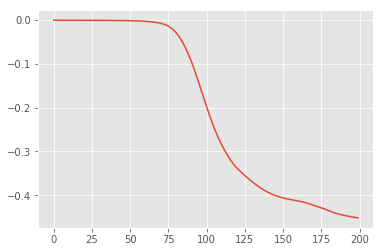

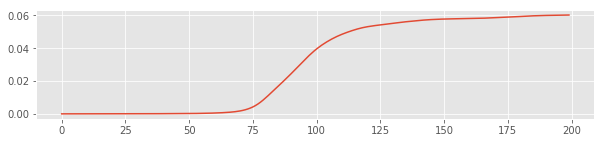

In [7]:
plt.plot(bleu_lb)
plt.show()
plt.figure(figsize=(10, 2))
plt.plot(grad_norms)
plt.show()

In [5]:
R = Variable(FloatTensor(onehot_initialization(\
                            np.array(references_batch), vocab_size).tolist()))
mbl = mBLEU()
mbl(R, probs, references_lengths, LongTensor([translation_len] * batch_size))

(slice(None, 200, None), slice(None, 10, None))


(Variable containing:
 -0.4517
 [torch.cuda.FloatTensor of size 1 (GPU 0)], [Variable containing:
   0.7448
  [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
   0.5819
  [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
   0.4041
  [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
   0.2377
  [torch.cuda.FloatTensor of size 1 (GPU 0)]])